<a href="https://colab.research.google.com/github/bhattacharya5/SpeechUnderstanding/blob/main/MMS_LID_Inference_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running MMS-LID inference in Colab

## Step 1: Clone fairseq-py and install latest version

In [1]:
import os

!git clone https://github.com/pytorch/fairseq

# Change current working directory
!pwd
%cd "/content/fairseq"
!pip install --editable ./
!pip install tensorboardX


Cloning into 'fairseq'...
remote: Enumerating objects: 35073, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 35073 (delta 0), reused 3 (delta 0), pack-reused 35061
Receiving objects: 100% (35073/35073), 25.11 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (25464/25464), done.
/content
/content/fairseq
Obtaining file:///content/fairseq
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Building edita

## 2. Download MMS-LID model



In [2]:
available_models = ["l126", "l256", "l512", "l1024", "l2048", "l4017"]

# We will use L126 model which can recognize 126 languages
model_name = available_models[0] # l126
print(f"Using model - {model_name}")
print(f"Visit https://dl.fbaipublicfiles.com/mms/lid/mms1b_{model_name}_langs.html to check all the languages supported by this model.")

! mkdir -p /content/models_lid
!wget -P /content/models_lid/{model_name} 'https://dl.fbaipublicfiles.com/mms/lid/mms1b_{model_name}.pt'
!wget -P /content/models_lid/{model_name} 'https://dl.fbaipublicfiles.com/mms/lid/dict/l126/dict.lang.txt'



Using model - l126
Visit https://dl.fbaipublicfiles.com/mms/lid/mms1b_l126_langs.html to check all the languages supported by this model.
--2024-01-28 05:05:13--  https://dl.fbaipublicfiles.com/mms/lid/mms1b_l126.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3856229421 (3.6G) [binary/octet-stream]
Saving to: ‘/content/models_lid/l126/mms1b_l126.pt’

mms1b_l126.pt       100%[===================>]   3.59G   177MB/s    in 26s     

2024-01-28 05:05:39 (142 MB/s) - ‘/content/models_lid/l126/mms1b_l126.pt’ saved [3856229421/3856229421]

--2024-01-28 05:05:39--  https://dl.fbaipublicfiles.com/mms/lid/dict/l126/dict.lang.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.51, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfil

## 3. Prepare manifest files
Create a folder on path '/content/audio_samples/' and upload your .wav audio files that you need to recognize e.g. '/content/audio_samples/abc.wav' , '/content/audio_samples/def.wav' etc...

Note: You need to make sure that the audio data you are using has a sample rate of 16kHz You can easily do this with FFMPEG like the example below that converts .mp3 file to .flac and fixing the audio sample rate

Here, we use three examples - one audio file from English, Hindi, Chinese each.

In [3]:
! mkdir -p /content/audio_samples/

In [19]:
#for key in ["en_us", "hi_in", "cmn_hans_cn"]:
#  !wget -O /content/audio_samples/tmp.mp3 /content/audio_samples/1.mp3
!ffmpeg -hide_banner -loglevel error -y -i   /content/audio_samples/1.mp3 -ar 16000 /content/audio_samples/1.wav
!ffmpeg -hide_banner -loglevel error -y -i   /content/audio_samples/2.mp3 -ar 16000 /content/audio_samples/2.wav

! mkdir -p /content/audio_samples/

In [5]:
! mkdir -p /content/manifest/
import os
with open("/content/manifest/dev.tsv", "w") as ftsv, open("/content/manifest/dev.lang", "w") as flang:
  ftsv.write("/\n")

  for fl in os.listdir("/content/audio_samples/"):
    if not fl.endswith(".wav"):
      continue
    audio_path = f"/content/audio_samples/{fl}"
    # duration should be number of samples in audio. For inference, using a random value should be fine.
    duration = 1234
    ftsv.write(f"{audio_path}\t{duration}\n")
    flang.write("eng\n") # This is the "true" language for the audio. For inference, using a random value should be fine.


# 4: Run Inference and transcribe your audio(s)


In [6]:
import os

os.environ["PYTHONPATH"] = "/content/fairseq"
os.environ["PREFIX"] = "INFER"
os.environ["HYDRA_FULL_ERROR"] = "1"
os.environ["USER"] = "mms_lid_user"

!python3 examples/mms/lid/infer.py /content/models_lid/{model_name} --path /content/models_lid/{model_name}/mms1b_l126.pt \
  --task audio_classification  --infer-manifest /content/manifest/dev.tsv --output-path /content/manifest/

2024-01-28 05:06:54.490666: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-28 05:06:54.490808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-28 05:06:54.616909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-28 05:06:54.859160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-28 05:06:57.019677: W tensorflow/compiler/tf2

In [7]:
print("----- INPUT FILES -----")
! tail -n +2 /content/manifest/dev.tsv

print("\n----- TOP-K PREDICTONS WITH SCORE -----")
! cat /content/manifest//predictions.txt

----- INPUT FILES -----
/content/audio_samples/1.wav	1234
/content/audio_samples/2.wav	1234

----- TOP-K PREDICTONS WITH SCORE -----
[["hin", 0.9778025150299072], ["urd", 0.007791353855282068], ["pan", 0.007627932354807854]]
[["guj", 0.4081483483314514], ["mar", 0.36899444460868835], ["kan", 0.05524643138051033]]


# Evaluate the model’s accuracy in identifying languages by comparing predicted and ground-truth languages. Analyze the model’s performance.

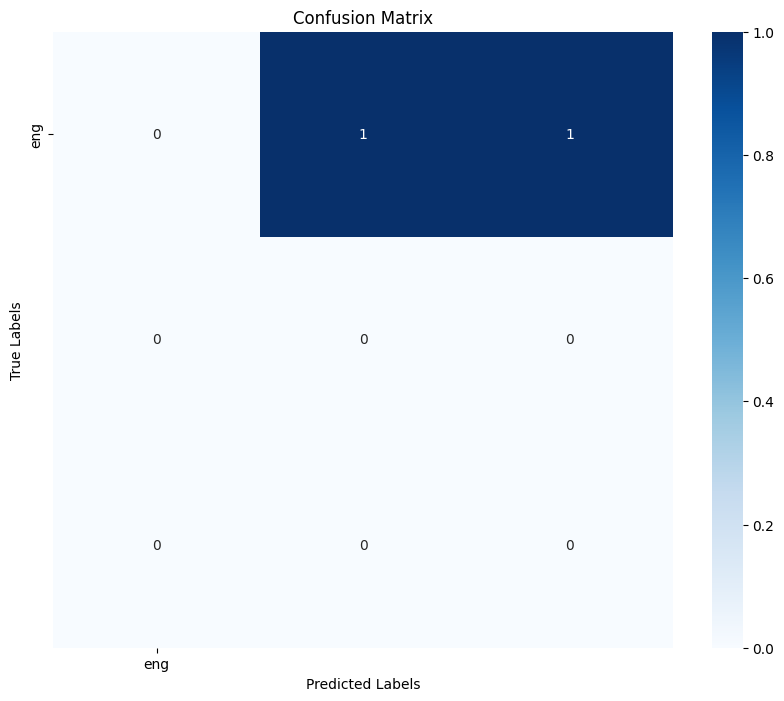

Classification Report:
               precision    recall  f1-score   support

         eng       0.00      0.00      0.00       2.0
         guj       0.00      0.00      0.00       0.0
         hin       0.00      0.00      0.00       0.0

    accuracy                           0.00       2.0
   macro avg       0.00      0.00      0.00       2.0
weighted avg       0.00      0.00      0.00       2.0

Accuracy within Confidence Threshold (0.5): 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [54]:
# Import necessary modules
from sklearn.metrics import confusion_matrix as cm, classification_report as cr
import seaborn as sns
import matplotlib.pyplot as plt

# Read ground truth labels from the manifest file
ground_truth_file_path_modified = "/content/manifest/dev.lang"  # Update with the correct path
with open(ground_truth_file_path_modified, 'r') as file:
    ground_truth_labels_modified = [line.strip() for line in file]


# Read predictions from the predictions.txt file
predictions_file_path_modified = "/content/manifest/predictions.txt"  # Update with the correct path
with open(predictions_file_path_modified, 'r') as file:
    predictions_lines_modified = [eval(line.strip()) for line in file]
# Extract predicted labels and confidence scores
top_predictions_modified = [line[0] for line in predictions_lines_modified]


# Ensure the lengths match before proceeding
if len(ground_truth_labels_modified) != len(top_predictions_modified):
    raise ValueError("Mismatch in the number of samples between ground truth and predictions.")

# Extract only the top predicted labels
predicted_labels_modified = [pred_mod[0] for pred_mod in top_predictions_modified]

# Generate confusion matrix
conf_matrix_modified = cm(ground_truth_labels_modified, predicted_labels_modified)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_modified, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(set(ground_truth_labels_modified)), yticklabels=sorted(set(ground_truth_labels_modified)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report_modified = cr(ground_truth_labels_modified, predicted_labels_modified)
print("Classification Report:\n", classification_report_modified)

confidence_threshold_modified = 0.5
high_confidence_predictions_modified = [pred_mod[0] if pred_mod[1] >= confidence_threshold_modified else 'unknown' for pred_mod in top_predictions_modified]

# Calculate accuracy within confidence threshold
high_confidence_correct_predictions_modified = [pred_mod == gt_mod for pred_mod, gt_mod in zip(high_confidence_predictions_modified, ground_truth_labels_modified)]
high_confidence_accuracy_modified = sum(high_confidence_correct_predictions_modified) / len(high_confidence_correct_predictions_modified)

print(f"Accuracy within Confidence Threshold ({confidence_threshold_modified}): {high_confidence_accuracy_modified * 100:.2f}%")
